 # Лабораторная работа №4

Выполнила Рындина Валерия, M33351

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from copy import copy
from scipy import stats
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, f1_score

1. Выберите один из датасетов первой лабораторной

In [2]:
dt_cases = pd.read_csv('data/raw/CasesWithDistance.csv')

2. Найдите в данных признак, который будете предсказывать

    * Если это категория, то у неё должно быть от 2 до 10 значений (например колонка species в датасете миграции птиц содержит 3 категории)

    * Если признак количественный, то его нужно дискретизировать (например для популярности трека в датасете spotify можно разделить треки на 3 категории: 0-20 - популярные, 21-50 - обычные, 51 - 100 - непопулярные). Полученную категорию записать в датафрейм как отдельную колонку

describe:
count     171.000000
mean       66.637427
std       358.109657
min         1.000000
25%         4.000000
50%        10.000000
75%        34.000000
max      4511.000000
Name: confirmed, dtype: float64


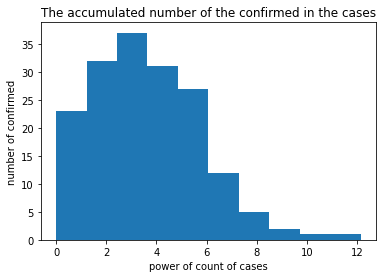

In [3]:
dt_cases = dt_cases.drop(dt_cases[dt_cases.confirmed <= 0].index)
sorted_confirmed = dt_cases.confirmed.sort_values(ascending=False)

print("describe:")
print(sorted_confirmed.describe())

plt.hist(np.log2(sorted_confirmed))
plt.title('The accumulated number of the confirmed in the cases')
plt.xlabel("power of count of cases")
plt.ylabel("number of confirmed")
plt.show()

* 1-4 : немного случаев заболевания
* 5-32 : средне
* 33+ : много

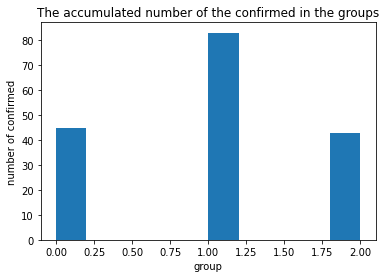

In [4]:
def create_confirmed_group(current_confirmed):
    if current_confirmed < 5:
        return 0
    if current_confirmed < 33:
        return 1
    return 2

dt_cases = dt_cases.assign(confirmedGroup=dt_cases.confirmed.apply(lambda x: create_confirmed_group(x)))

plt.hist(dt_cases.confirmedGroup)
plt.title('The accumulated number of the confirmed in the groups')
plt.xlabel("group")
plt.ylabel("number of confirmed")
plt.show()

# dt_cases = dt_cases.assign(hashProvince=dt_cases.province.apply(lambda x: hash(x)))
# dt_cases = dt_cases.assign(hashCity=dt_cases.city.apply(lambda x: hash(x)))
dt_cases = dt_cases.assign(new_id=dt_cases.case_id.apply(lambda x: x % 100))

dt_cases.to_csv('../Lab5/data/raw/Case.csv')

3. Выделите признаки для предсказания

    Используйте от 2 до 5 количественных признаков для предсказания целевой переменной

In [5]:
marks = ['distance','new_id','latitude','longitude']

x = dt_cases[marks].values.tolist()
y = dt_cases.confirmedGroup.values.tolist()

x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True, stratify=y, test_size=0.3)


In [6]:
knn_clf = KNeighborsClassifier()
svm_clf = SVC()
forest_clf = RandomForestClassifier()

# Обучим классификаторы на тренировочных данных
for clf in [knn_clf, svm_clf, forest_clf]:
    clf.fit(x_train, y_train)

# Получим значение метки для тестового набора
knn_pred = knn_clf.predict(x_test)
svm_pred = svm_clf.predict(x_test)
forest_pred = forest_clf.predict(x_test)

4. Проверьте нормальность количественных признаков

    Используйте статистический тест из лекции. Если распределение является лог-нормальным, логарифмируйте его и проверьте на нормальность

    Как минимум 1 из признаков должен быть нормальным

NormaltestResult(statistic=6.36338877516726, pvalue=0.041515252564930834)


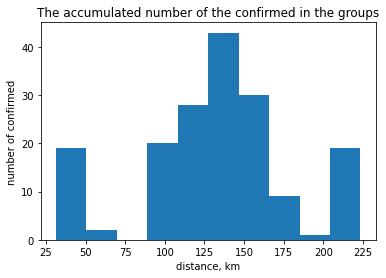

In [7]:
print(stats.normaltest(dt_cases.distance))
plt.hist(dt_cases.distance)
plt.title('The accumulated number of the confirmed in the groups')
plt.xlabel("distance, km")
plt.ylabel("number of confirmed")
plt.show()

5. Покажите качество предсказания модели с помощью метрик

    Метрика должна учитывать баланс классов в датасете

In [8]:
for (name, pred) in [('KNeighborsClassifier', knn_pred), ('SVC', svm_pred), ('RandomForestClassifier', forest_pred)]:
    acc_score = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average="weighted")
    f1 = f1_score(y_test, pred, average='weighted')

    leaderboard = sorted([
        ('accuracy', acc_score),
        ('precision', precision),
        ('f1', f1)
    ], key=lambda pair: pair[1], reverse=True)

    print('Leaderboard of',name,':')
    for idx, (leader_name, leader_score) in enumerate(leaderboard):
        print(f'{idx + 1}. {leader_name}: {leader_score}')
    print()


Leaderboard of KNeighborsClassifier :
1. precision: 0.6738782051282051
2. f1: 0.6390094499338197
3. accuracy: 0.6346153846153846

Leaderboard of SVC :
1. accuracy: 0.4807692307692308
2. f1: 0.31218781218781216
3. precision: 0.2311390532544379

Leaderboard of RandomForestClassifier :
1. precision: 0.7015050167224081
2. f1: 0.695673076923077
3. accuracy: 0.6923076923076923



/home/valrun/Repositories/CT-19/5 sem/pythonProject/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
